In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [99]:
import sys
import os

import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from tqdm import tqdm
import json
utils.reset_seeds(0)


In [93]:
pd.set_option('display.max_columns', 50)

In [133]:
df = pd.read_csv("andmed/order2_const.csv")
df_reverse = pd.read_csv("andmed/reverse2_const.csv")

In [134]:
# Kosmeetilised muudatused

### õiget pidi
df.train_size = df.train_size.astype(int)
df.random_seed = df.random_seed.astype(int)
df.multiplier = df.multiplier.astype(float)
for i in range(5):
    df[f"ext_bpoints_in_{chr(i+ord('a'))}"] = df[f"ext_bpoints_in_{chr(i+ord('a'))}"].astype(int)

# lisame mugavusväärtused
df["points_in_equal_regions"] = (df["train_size"] / 5).astype(int)
df["points_in_diff_region"] =  (df["points_in_equal_regions"] * df["multiplier"]).astype(int)
df["total_points"] = 4*df["points_in_equal_regions"] + df["points_in_diff_region"]

# tuunime välja väga kauged sampled
df = df[df.abs_diff_in_a>-3]
df = df[df.raw_mean3_in_a<0.7]


### tagurpidi noise
df_reverse.train_size = df_reverse.train_size.astype(int)
df_reverse.random_seed = df_reverse.random_seed.astype(int)
df_reverse.multiplier = df_reverse.multiplier.astype(float)
for i in range(5):
    df_reverse[f"ext_bpoints_in_{chr(i+ord('a'))}"] = df_reverse[f"ext_bpoints_in_{chr(i+ord('a'))}"].astype(int)

# lisame mugavusväärtused
df_reverse["points_in_equal_regions"] = (df_reverse["train_size"] / 5).astype(int)
df_reverse["points_in_diff_region"] =  (df_reverse["points_in_equal_regions"] * df_reverse["multiplier"]).astype(int)
df_reverse["total_points"] = 4*df_reverse["points_in_equal_regions"] + df_reverse["points_in_diff_region"]

# tuunime välja väga kauged sampled
df_reverse = df_reverse[df_reverse.abs_diff_in_a < 100]


In [135]:
df.sort_values(by=["train_size", "region", "multiplier", "random_seed"], inplace=True, ignore_index=True)
df = df.groupby(['region', 'multiplier', 'train_size']).mean().reset_index()

df["combo_name"] = df["train_size"].astype(str) + "_" + df["region"] + "_" + df["multiplier"].astype(str)


df_reverse.sort_values(by=["train_size", "region", "multiplier", "random_seed"], inplace=True, ignore_index=True)
df_reverse = df_reverse.groupby(['region', 'multiplier', 'train_size']).mean().reset_index()
df_reverse["combo_name"] = df_reverse["train_size"].astype(str) + "_" + df_reverse["region"] + "_" + df_reverse["multiplier"].astype(str)

<AxesSubplot: >

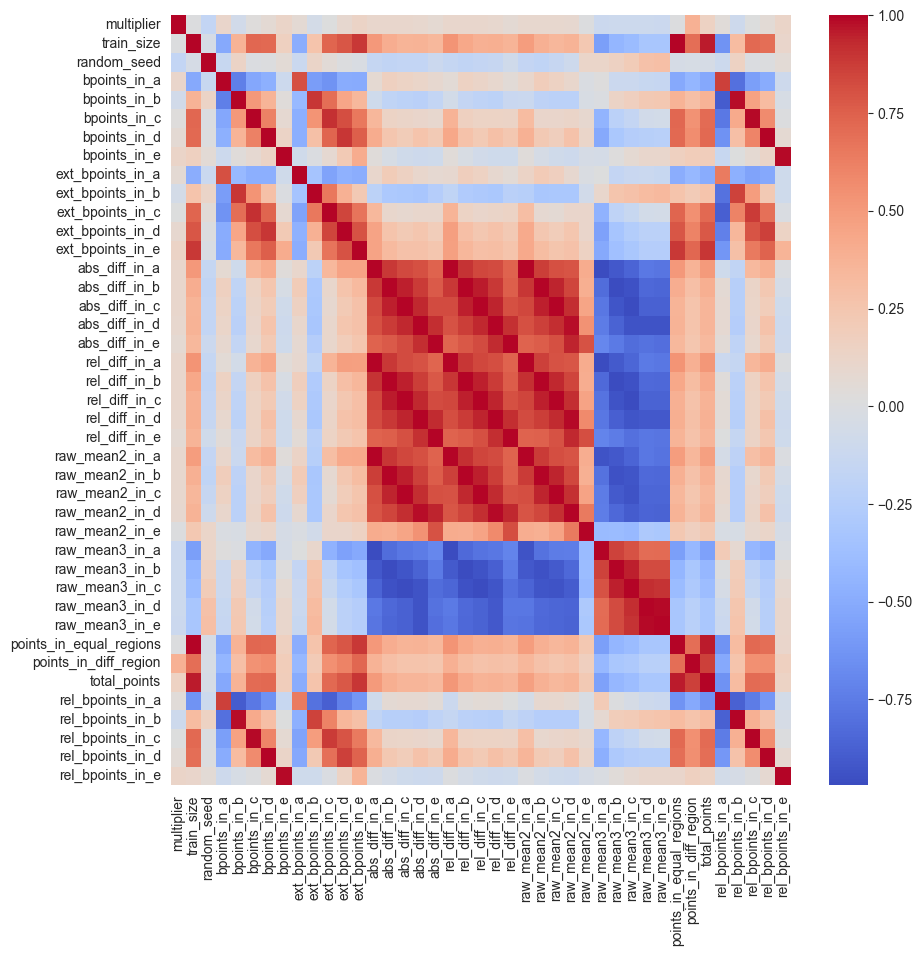

In [230]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")

<AxesSubplot: >

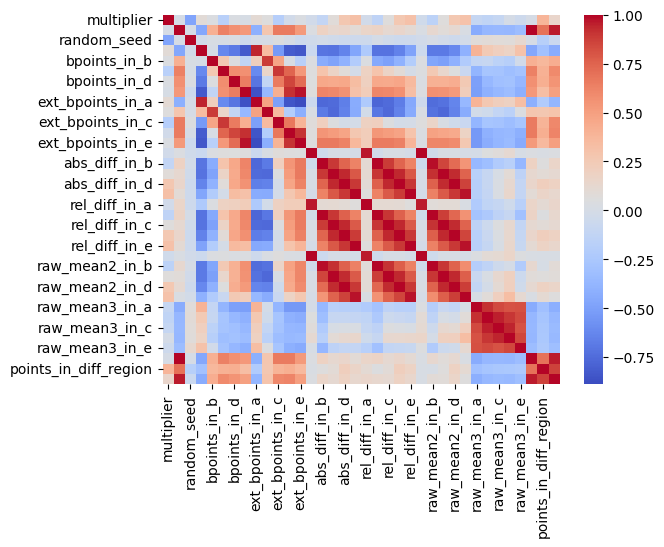

In [67]:
sns.heatmap(df_reverse.corr(numeric_only=True), cmap="coolwarm")

## Joonistame 

In [102]:
sns.set_style("whitegrid")

<AxesSubplot: xlabel='points_in_equal_regions', ylabel='bpoints_in_a'>

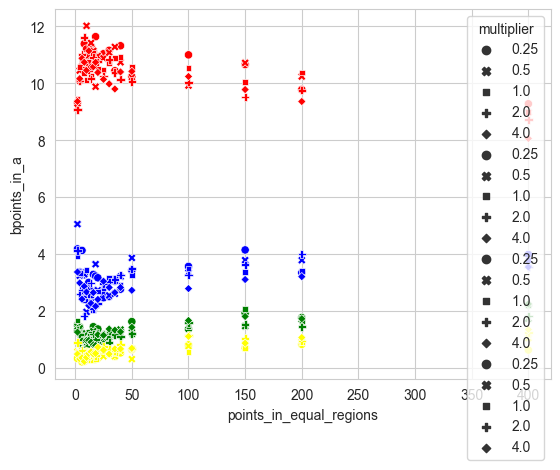

In [107]:
test_df = df[df.region=="E"]
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="bpoints_in_a",color="red", style="multiplier")
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="bpoints_in_b",color="blue", style="multiplier")
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="bpoints_in_c",color="green", style="multiplier")
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="bpoints_in_d",color="yellow", style="multiplier")

<AxesSubplot: xlabel='points_in_diff_region', ylabel='rel_diff_in_c'>

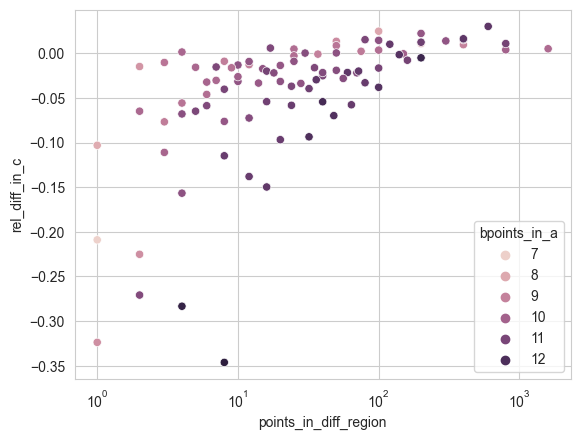

In [116]:
test_df = df[(df.region=="A")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots()
ax.set_xscale( "log")
#sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_a",ax=ax)#hue_norm=LogNorm() )
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_a",)#ax=ax)#hue_norm=LogNorm() )
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_b",hue="multiplier")
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_c",hue="multiplier")
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_d",hue="multiplier")
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_e",hue="multiplier")

In [128]:
test_df.corr(numeric_only=True).shape

(36, 36)

<AxesSubplot: >

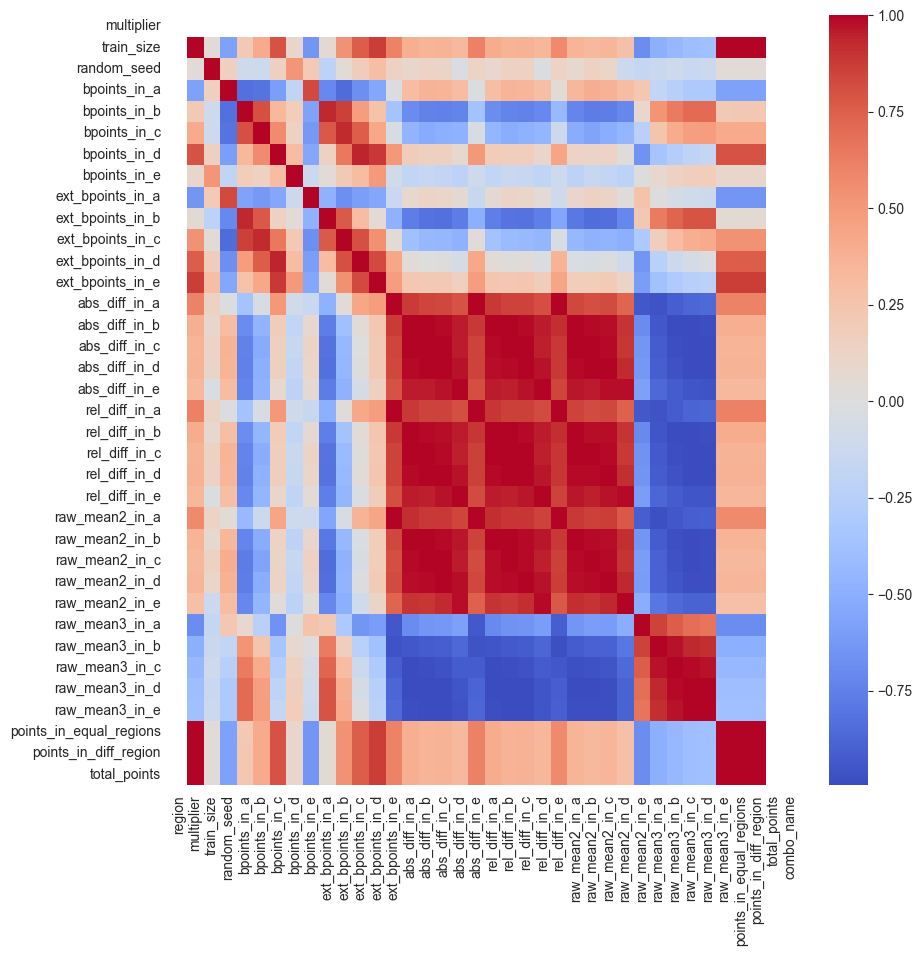

In [139]:
test_df = df[(df.region == "A") & (
    df.points_in_diff_region != 0) & (df.multiplier == 0.5)]
plt.figure(figsize=(10, 10))
sns.heatmap(test_df.corr(numeric_only=True), cmap="coolwarm",
            xticklabels=test_df.columns, yticklabels=1,)


## pts_diff_reg vs rel_diff_in_
multiplieriga välja filtreerimine ei muuda väga midagist.

### region A 

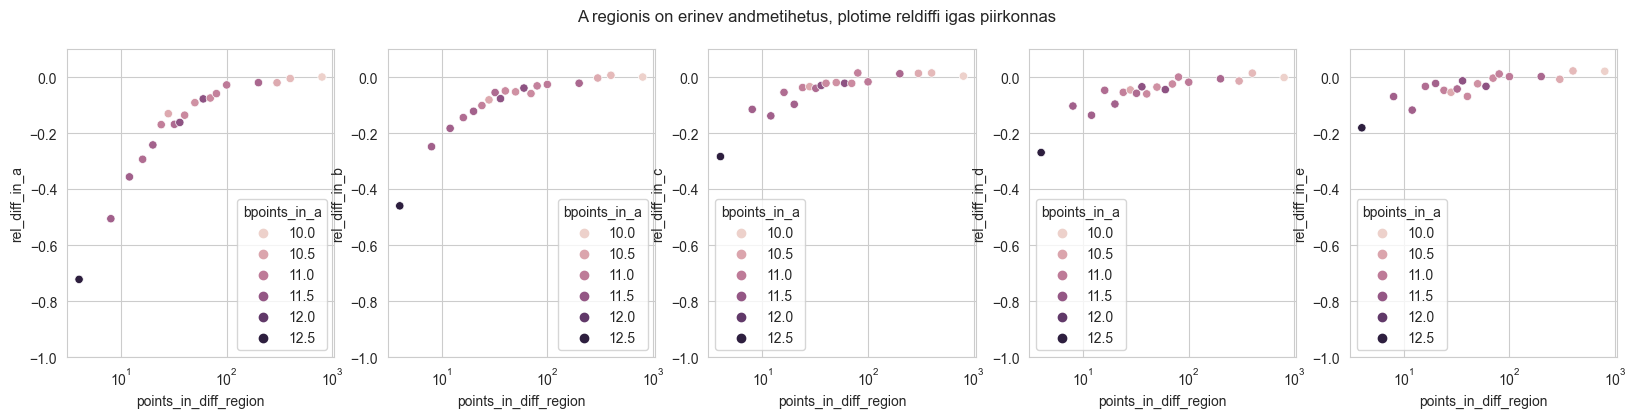

In [234]:
test_df = df[(df.region=="A")&(df.points_in_diff_region!=0)&(df.multiplier==2)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
# plt.legend(loc='lower right')
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_a" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_a", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_a", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_a", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_a", ax=ax[4])
plt.suptitle("A regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas")
plt.show()

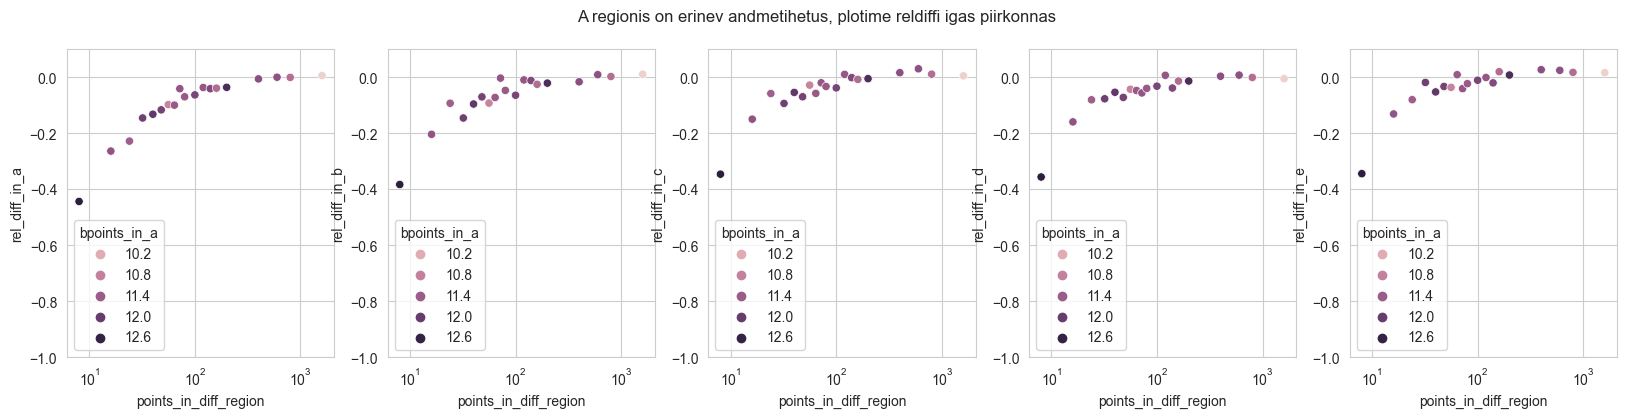

In [190]:
test_df = df[(df.region=="A")&(df.points_in_diff_region!=0) &(df.multiplier==4)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
# plt.legend(loc='lower right')
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_a" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_a", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_a", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_a", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_a", ax=ax[4])
plt.suptitle("A regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas")
plt.show()

In [259]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [237]:
df.columns

Index(['region', 'multiplier', 'train_size', 'random_seed', 'bpoints_in_a',
       'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
       'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c',
       'ext_bpoints_in_d', 'ext_bpoints_in_e', 'abs_diff_in_a',
       'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
       'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d',
       'rel_diff_in_e', 'raw_mean2_in_a', 'raw_mean2_in_b', 'raw_mean2_in_c',
       'raw_mean2_in_d', 'raw_mean2_in_e', 'raw_mean3_in_a', 'raw_mean3_in_b',
       'raw_mean3_in_c', 'raw_mean3_in_d', 'raw_mean3_in_e',
       'points_in_equal_regions', 'points_in_diff_region', 'total_points',
       'combo_name', 'rel_bpoints_in_a', 'rel_bpoints_in_b',
       'rel_bpoints_in_c', 'rel_bpoints_in_d', 'rel_bpoints_in_e'],
      dtype='object')

In [267]:
ridge_df = df.copy()
ridge_df = ridge_df[ridge_df.points_in_diff_region != 0]
ridge_df["log_diff_region"] = np.log(ridge_df["points_in_diff_region"])
ridge_df["diff_region_m1"] = ridge_df["points_in_diff_region"] ** (-1)
ridge_df["diff_region_m2"] = ridge_df["points_in_diff_region"] ** (-2)
ridge_df["diff_region_m3"] = ridge_df["points_in_diff_region"] ** (-3)

# 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
# 'points_in_equal_regions', 'points_in_diff_region', 'total_points',


#              'abs_diff_in_a', 'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
#              'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d', 'rel_diff_in_e',
ridge_df = ridge_df[['region', 'multiplier', 'train_size', "log_diff_region", "points_in_diff_region", "points_in_equal_regions",
                     "diff_region_m1", "diff_region_m2", "diff_region_m3",

              'bpoints_in_a', 'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
              "rel_diff_in_a"]]
ohe = OneHotEncoder()
ohetud_region = ohe.fit_transform(ridge_df[["region"]])
ridge_df = pd.concat([ridge_df, pd.DataFrame(ohetud_region.toarray(), columns=ohe.categories_)], axis=1)
ridge_df.drop(columns=["region"], inplace=True)

ridge_df.dropna(inplace=True)
ridge_df.head()
X = ridge_df.drop(columns=["rel_diff_in_a"])
y = ridge_df["rel_diff_in_a"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


In [270]:
X.head()

,multiplier,train_size,log_diff_region,points_in_diff_region,points_in_equal_regions,diff_region_m1,diff_region_m2,diff_region_m3,bpoints_in_a,bpoints_in_b,bpoints_in_c,bpoints_in_d,bpoints_in_e,"(A,)","(B,)","(C,)","(D,)","(E,)"
1,0.25,20.0,0.000000,1.0,4.0,1.000000,1.000000,1.000000,6.945946,5.891892,1.243243,0.891892,0.108108,1.0,0.0,0.0,0.0,0.0
2,0.25,30.0,0.000000,1.0,6.0,1.000000,1.000000,1.000000,7.904762,5.571429,1.357143,0.523810,0.071429,1.0,0.0,0.0,0.0,0.0
3,0.25,40.0,0.693147,2.0,8.0,0.500000,0.250000,0.125000,8.510638,4.808511,1.319149,0.489362,0.106383,1.0,0.0,0.0,0.0,0.0
4,0.25,50.0,0.693147,2.0,10.0,0.500000,0.250000,0.125000,9.782609,3.739130,0.978261,0.391304,0.086957,1.0,0.0,0.0,0.0,0.0
5,0.25,60.0,1.098612,3.0,12.0,0.333333,0.111111,0.037037,9.177778,4.088889,0.933333,0.444444,0.066667,1.0,0.0,0.0,0.0,0.0


In [272]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Ridge()

In [273]:
clf.score(X_test, y_test)

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


0.8362690990625623

In [275]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, clf.predict(X_test))

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


0.00859416183493414

In [277]:
for n, c in zip(X.columns, clf.coef_):
    print(f"{n}: {c}")

multiplier: -0.10522134356972845
train_size: -0.00010534723837184153
log_diff_region: 0.1703254479489486
points_in_diff_region: 1.7417092944856028e-05
points_in_equal_regions: -2.1069451752298656e-05
diff_region_m1: -0.026074310340589376
diff_region_m2: 0.019081369047968866
diff_region_m3: 0.03957567260742163
bpoints_in_a: 0.023715465278669804
bpoints_in_b: -0.0425664167456727
bpoints_in_c: 0.026210103117804827
bpoints_in_d: -0.029277907515417707
bpoints_in_e: 0.021624672472539644
('A',): 0.0062169362619651615
('B',): 0.003909980356904968
('C',): 0.000265121491194202
('D',): -0.0064996670232488375
('E',): -0.0038923710868128945


In [278]:
from sklearn.linear_model import Lasso

In [288]:
clf = Lasso(alpha=0.01)
clf.fit(X_train, y_train)

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e+00, tolerance: 1.549e-03
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.01)

In [289]:
mean_squared_error(y_test, clf.predict(X_test))

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


0.010101798777618461

In [290]:
for n, c in zip(X.columns, clf.coef_):
    print(f"{n}: {c}")

multiplier: -0.08126816005899286
train_size: -9.561137717717686e-06
log_diff_region: 0.147779722617853
points_in_diff_region: -3.806462842724944e-05
points_in_equal_regions: -0.0002502872021216598
diff_region_m1: -0.0
diff_region_m2: -0.0
diff_region_m3: -0.0
bpoints_in_a: 0.016484913616481654
bpoints_in_b: -0.01592911452692823
bpoints_in_c: 0.0
bpoints_in_d: -0.0
bpoints_in_e: -0.0
('A',): 0.0
('B',): 0.0
('C',): -0.0
('D',): -0.0
('E',): -0.0


## Funktisoonipere
 - a_0 + e ** (a_1 - a_2 * x)
 - 

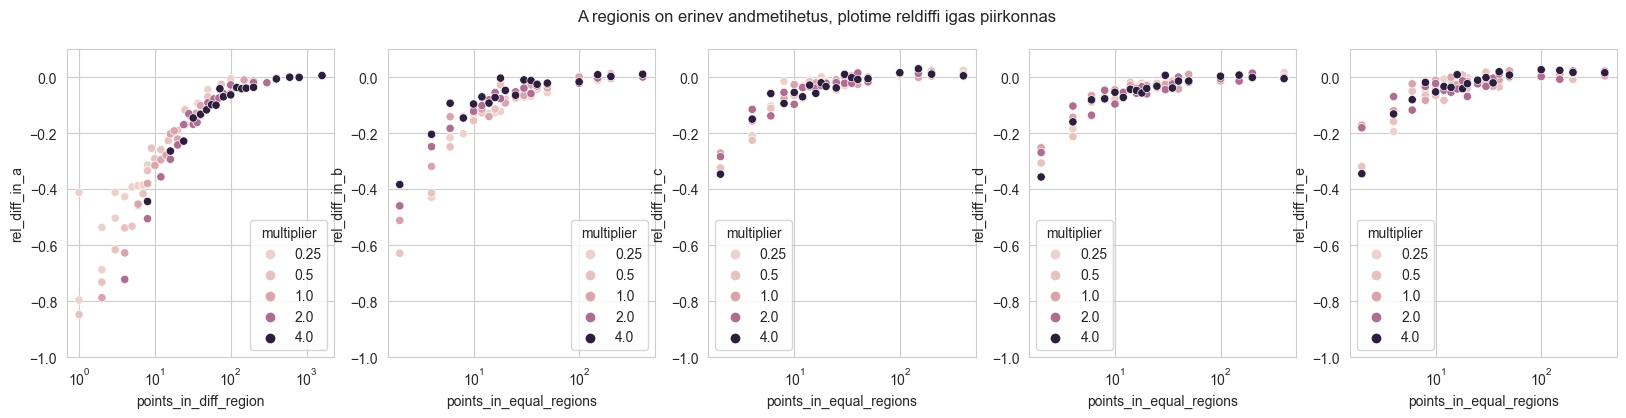

In [231]:
test_df = df[(df.region=="A")&(df.points_in_diff_region!=0)] #&(df.multiplier==2)
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
# plt.legend(loc='lower right')
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="multiplier" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="rel_diff_in_b",hue="multiplier", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="rel_diff_in_c",hue="multiplier", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="rel_diff_in_d",hue="multiplier", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="rel_diff_in_e",hue="multiplier", ax=ax[4])
plt.suptitle("A regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas")
plt.show()

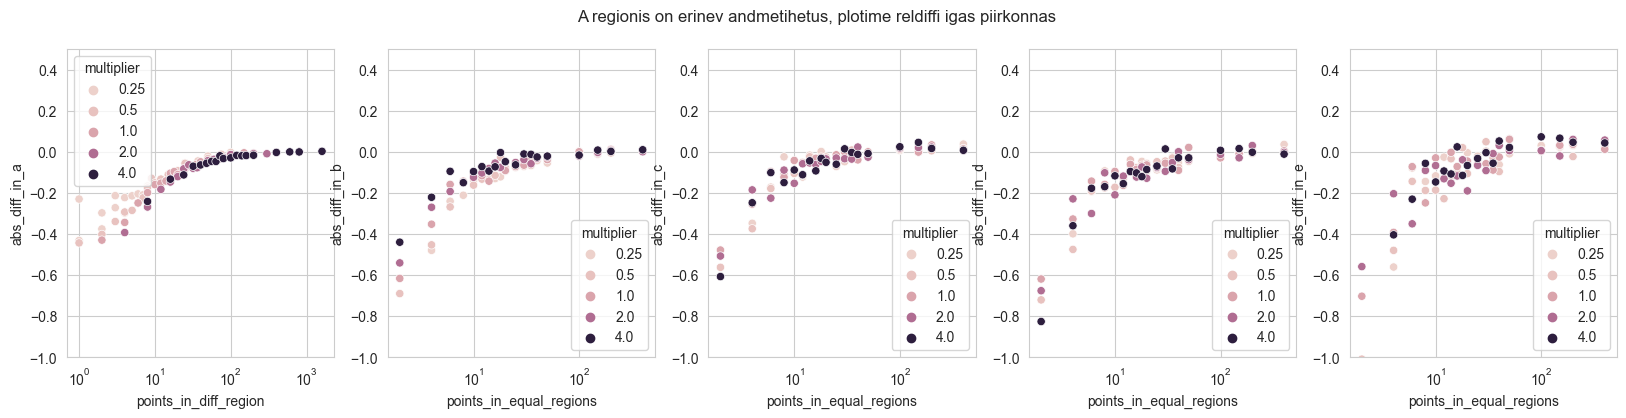

In [233]:
test_df = df[(df.region=="A")&(df.points_in_diff_region!=0)] #&(df.multiplier==2)
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.5) for a in ax]
# plt.legend(loc='lower right')
sns.scatterplot(data = test_df, x="points_in_diff_region",y="abs_diff_in_a",hue="multiplier" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="abs_diff_in_b",hue="multiplier", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="abs_diff_in_c",hue="multiplier", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="abs_diff_in_d",hue="multiplier", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="abs_diff_in_e",hue="multiplier", ax=ax[4])
plt.suptitle("A regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas")
plt.show()

### region B
- bpoints_a : natukene: rohkem bpoint -> halvem rel_dif
- bpoints_b on mida rohkem andmeid, seda rohkem bpointe?
- bpoints_c on rohkem bpoint-> parem rel_diff
- bpoints_d : rohkem bpoint-> parem rel_diff
- bpoints_e : suvaline

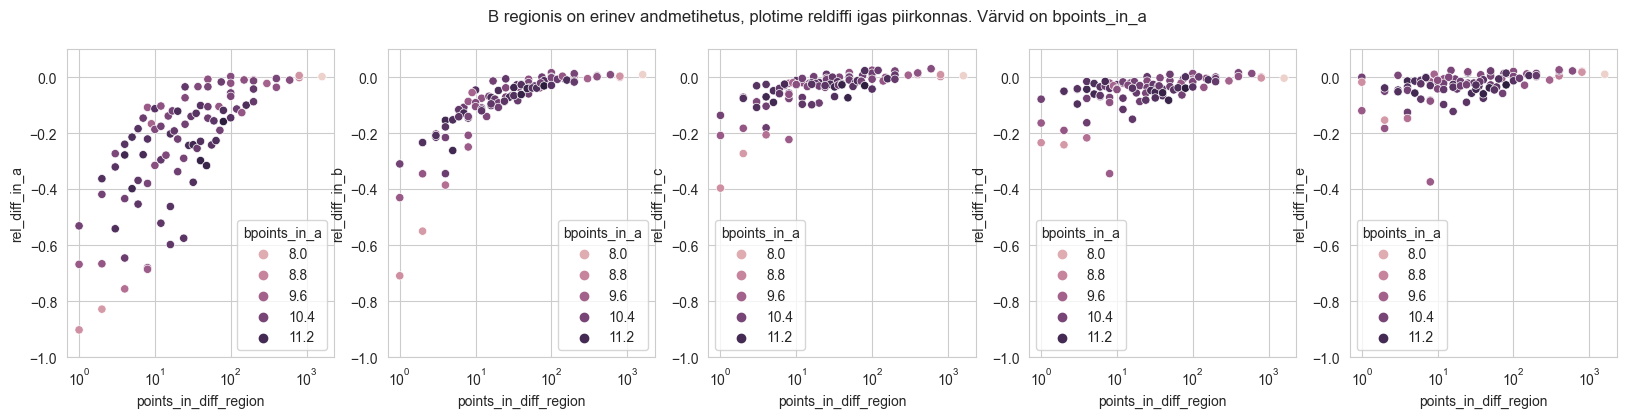

In [196]:
test_df = df[(df.region=="B")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_a" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_a", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_a", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_a", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_a", ax=ax[4])
plt.suptitle("B regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_a")
plt.show()

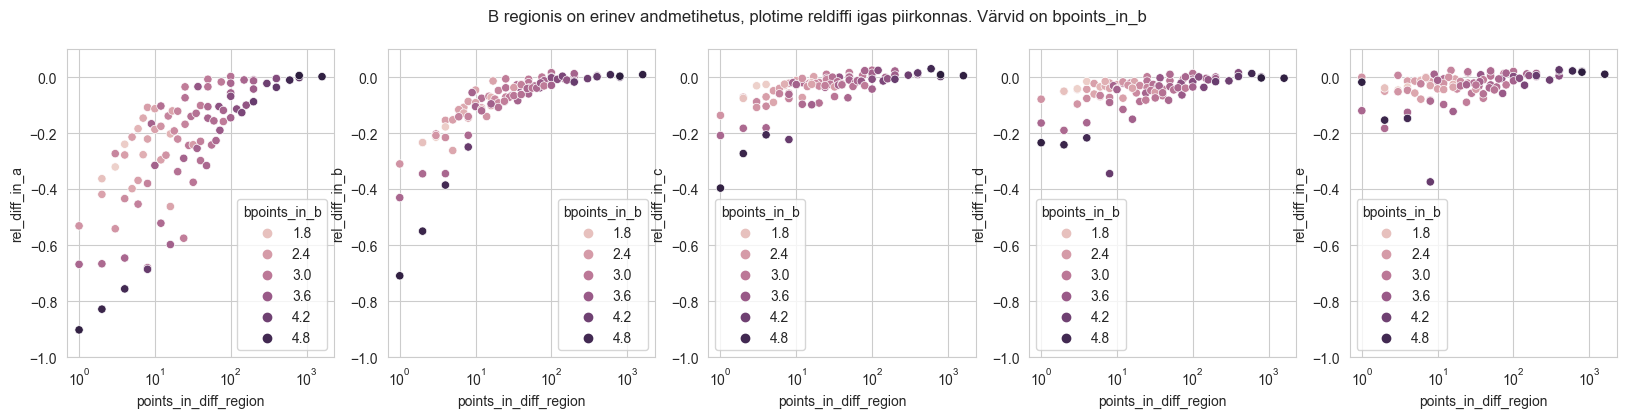

In [197]:
test_df = df[(df.region=="B")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_b" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_b", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_b", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_b", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_b", ax=ax[4])
plt.suptitle("B regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_b")
plt.show()

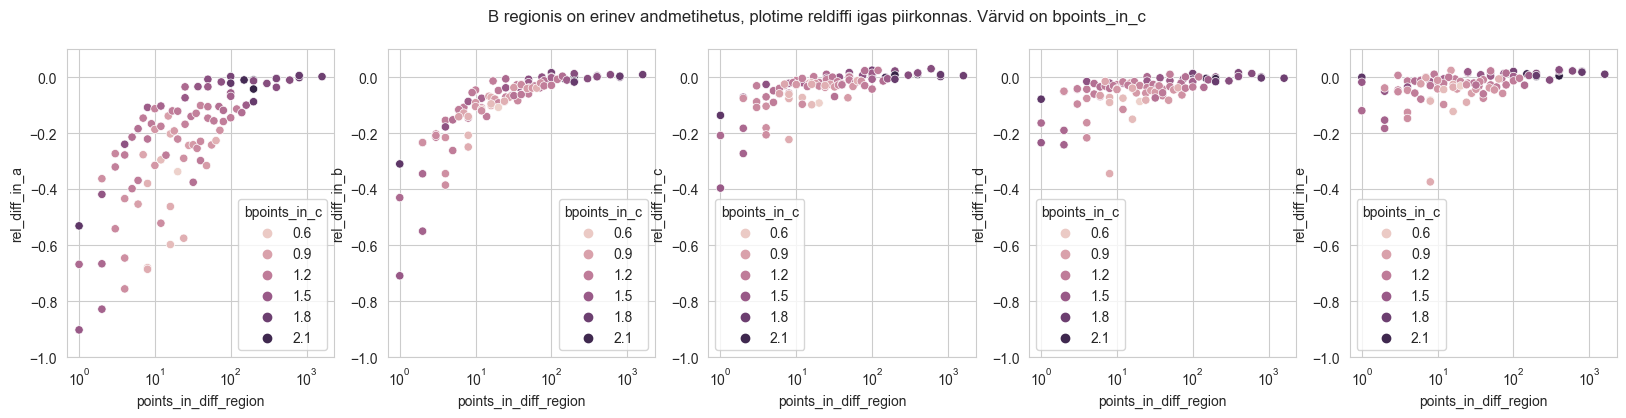

In [198]:
test_df = df[(df.region=="B")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_c" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_c", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_c", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_c", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_c", ax=ax[4])
plt.suptitle("B regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_c")
plt.show()

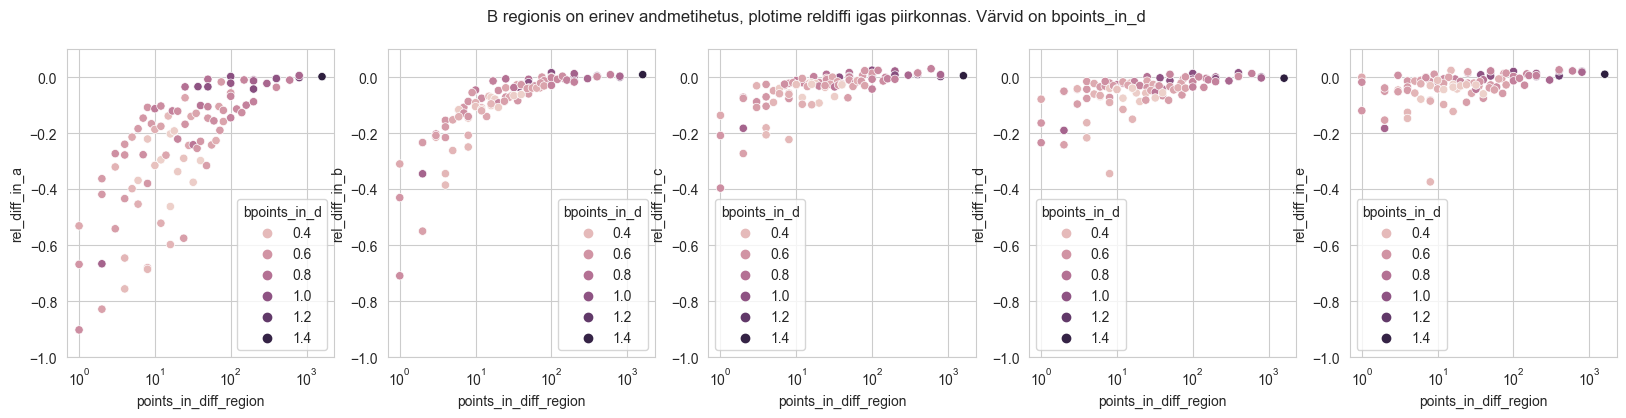

In [199]:
test_df = df[(df.region=="B")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_d" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_d", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_d", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_d", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_d", ax=ax[4])
plt.suptitle("B regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_d")
plt.show()

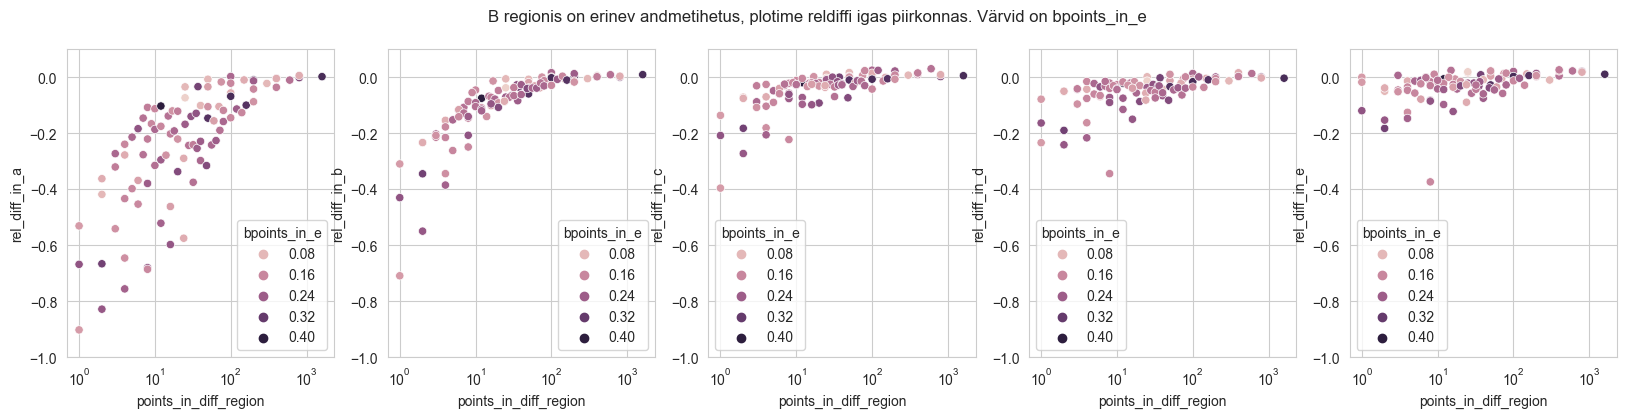

In [200]:
test_df = df[(df.region=="B")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_e" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_e", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_e", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_e", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_e", ax=ax[4])
plt.suptitle("B regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_e")
plt.show()

### region C
- bpoints_a : natukene : vähem bpointe parem
- bpoints_b : keskmine kogus bpointe on parem
- bpoints_c : rohkem bpointe on parem
- bpoints_d : rohkem bpointe on parem
- bpoints_e : suvaline 

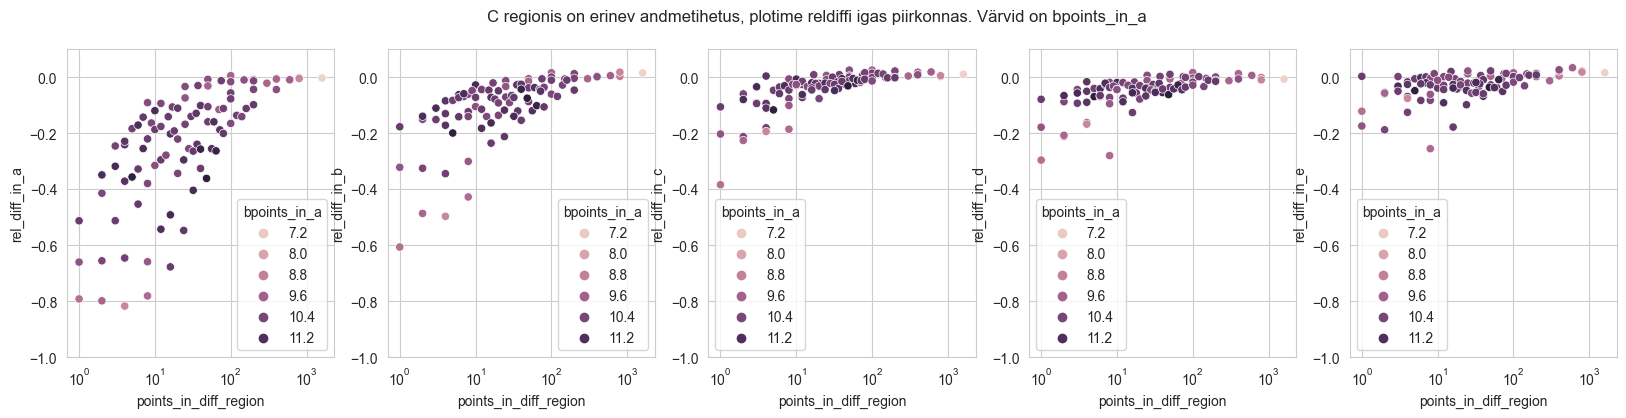

In [202]:
test_df = df[(df.region=="C")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_a" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_a", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_a", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_a", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_a", ax=ax[4])
plt.suptitle("C regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_a")
plt.show()

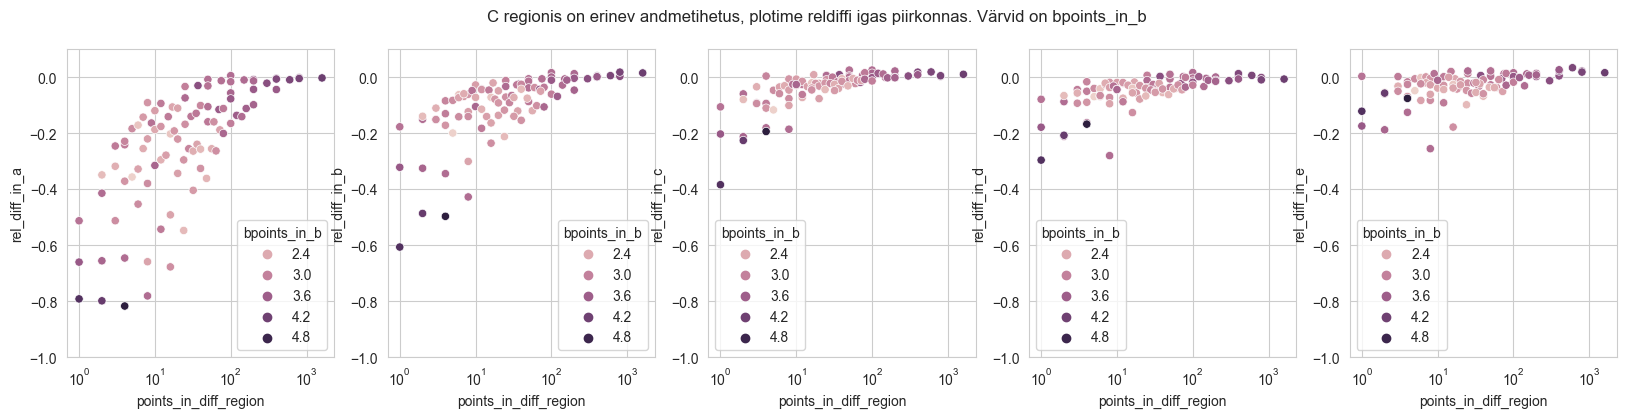

In [203]:
test_df = df[(df.region=="C")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_b" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_b", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_b", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_b", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_b", ax=ax[4])
plt.suptitle("C regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_b")
plt.show()

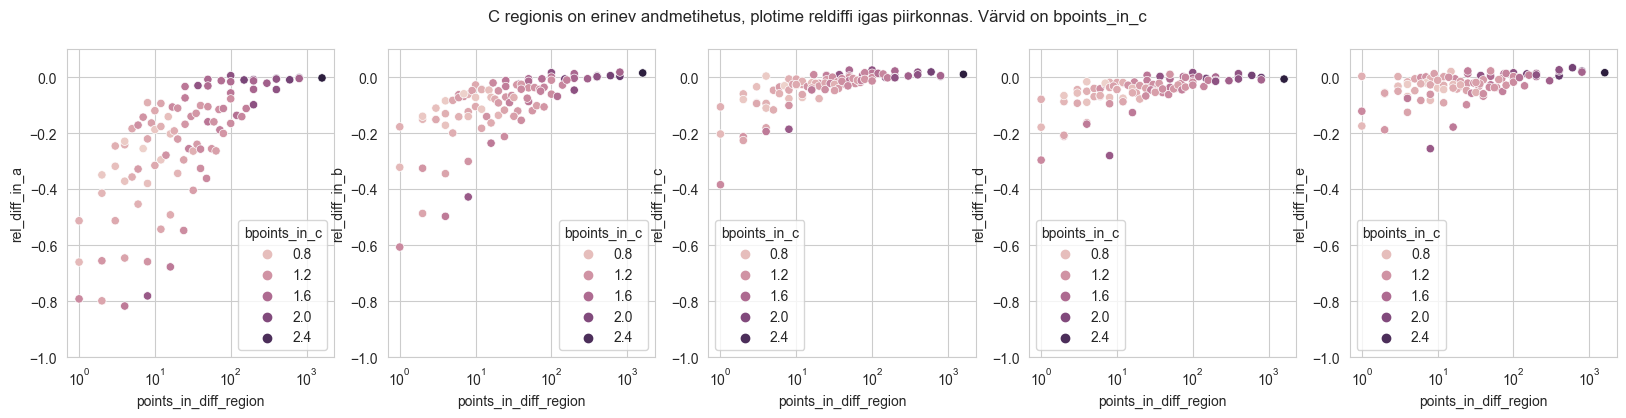

In [204]:
test_df = df[(df.region=="C")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_c" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_c", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_c", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_c", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_c", ax=ax[4])
plt.suptitle("C regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_c")
plt.show()

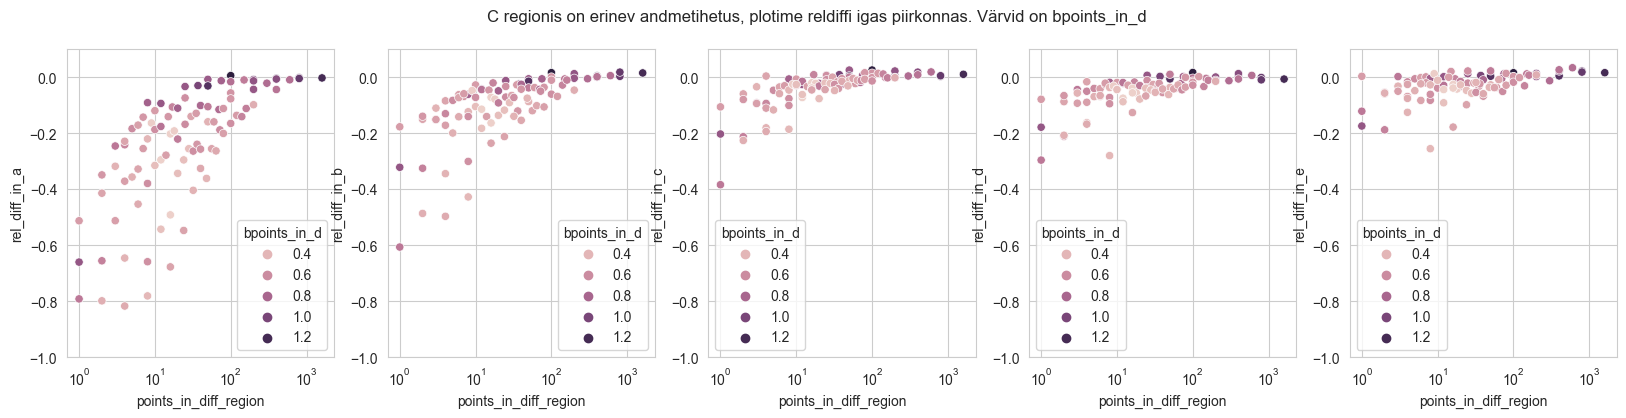

In [205]:
test_df = df[(df.region=="C")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_d" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_d", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_d", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_d", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_d", ax=ax[4])
plt.suptitle("C regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_d")
plt.show()

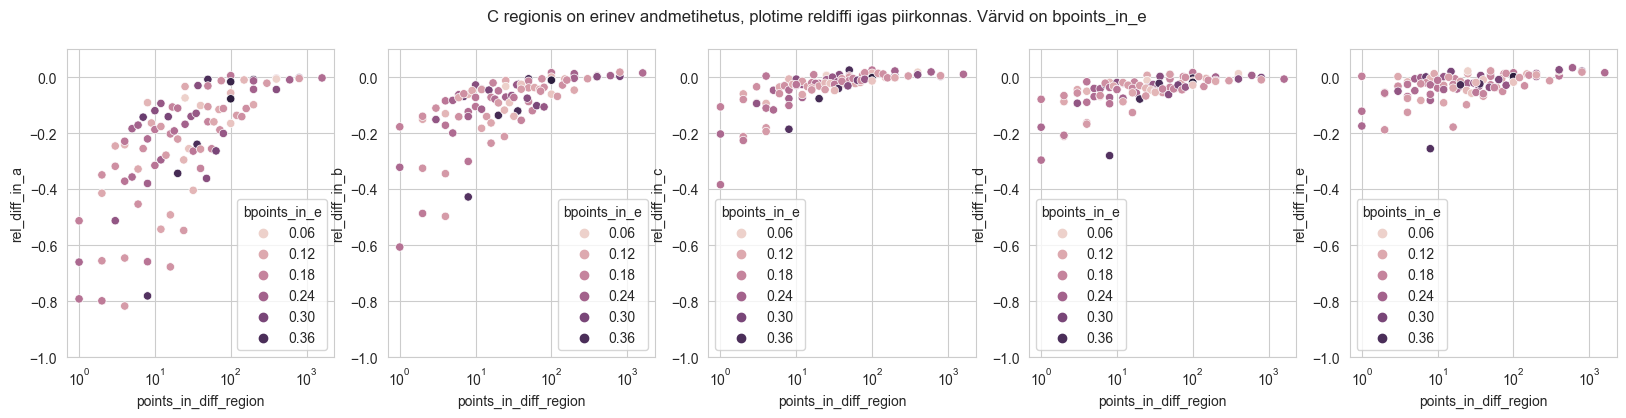

In [206]:
test_df = df[(df.region=="C")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_e" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_e", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_e", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_e", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_e", ax=ax[4])
plt.suptitle("C regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_e")
plt.show()

### region E
- 

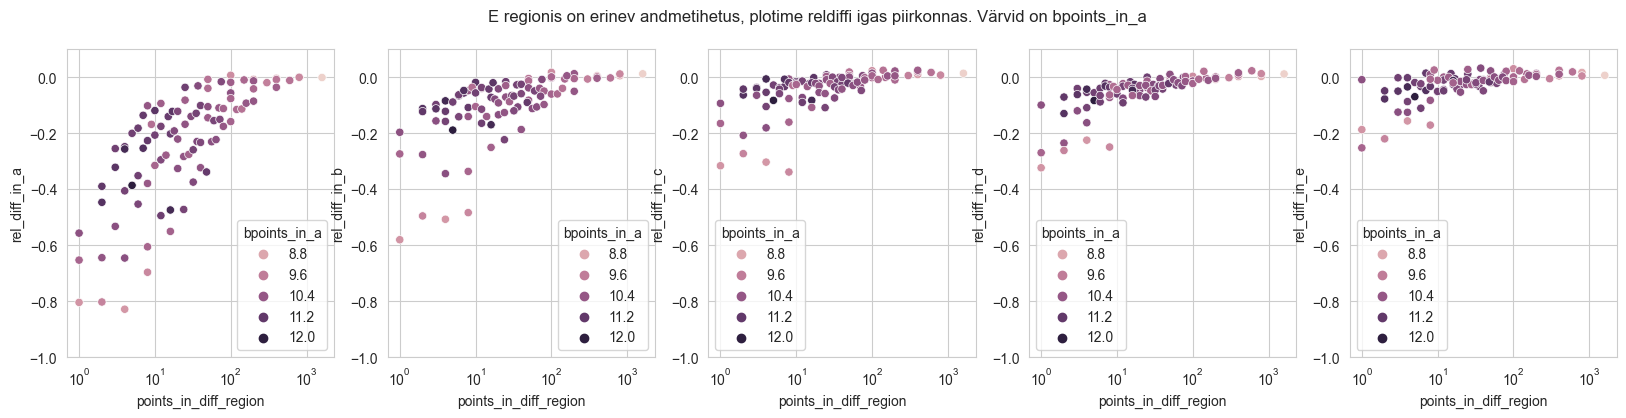

In [207]:
test_df = df[(df.region=="E")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_a" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_a", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_a", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_a", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_a", ax=ax[4])
plt.suptitle("E regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_a")
plt.show()

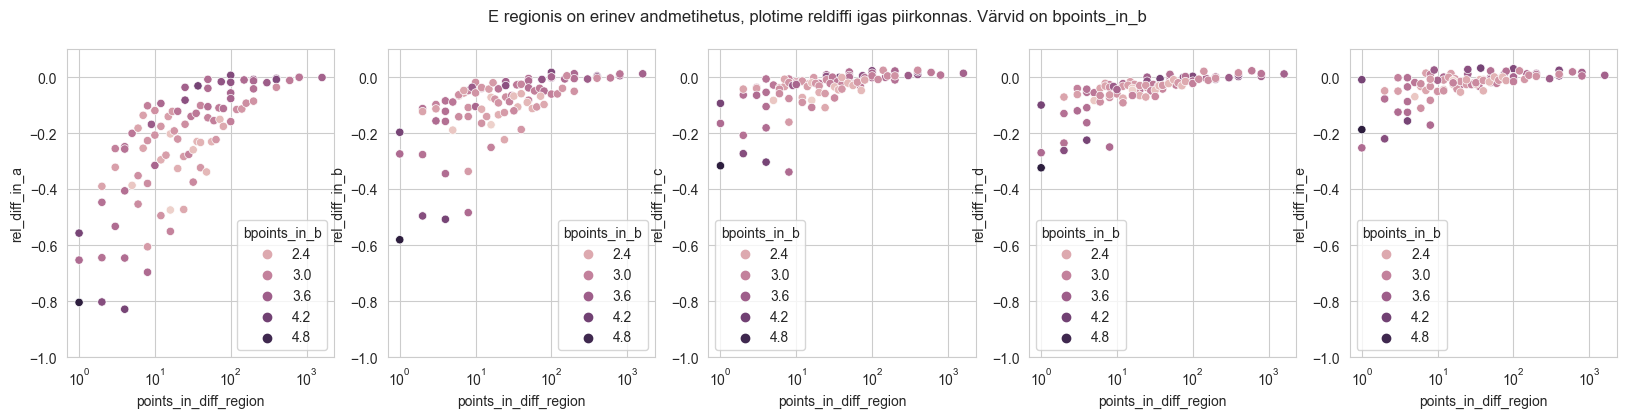

In [208]:
test_df = df[(df.region=="E")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_b" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_b", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_b", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_b", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_b", ax=ax[4])
plt.suptitle("E regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_b")
plt.show()

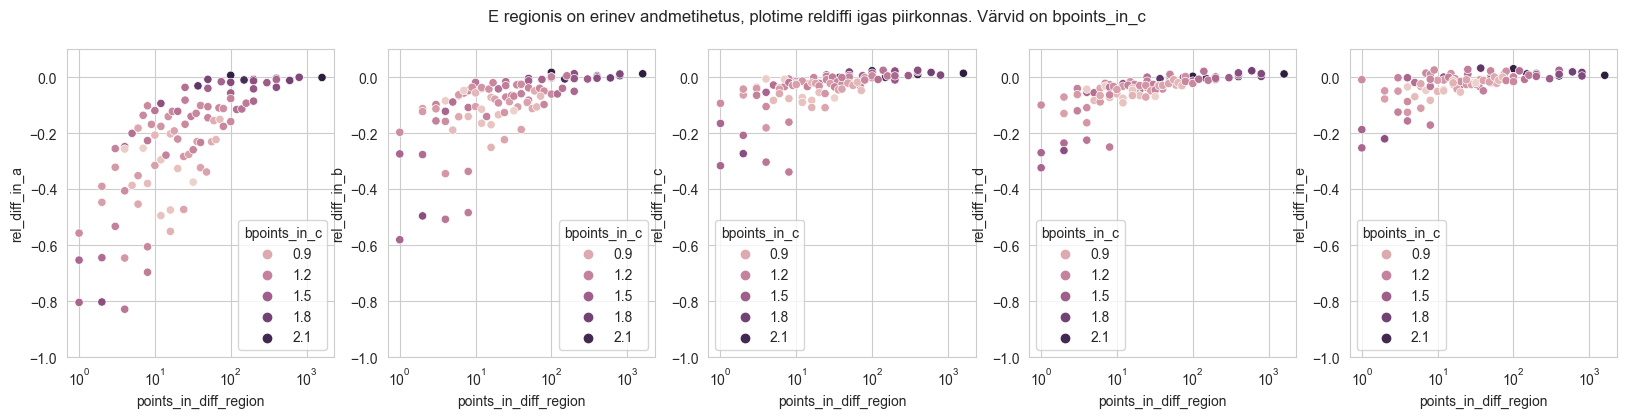

In [209]:
test_df = df[(df.region=="E")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_c" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_c", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_c", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_c", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_c", ax=ax[4])
plt.suptitle("E regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_c")
plt.show()

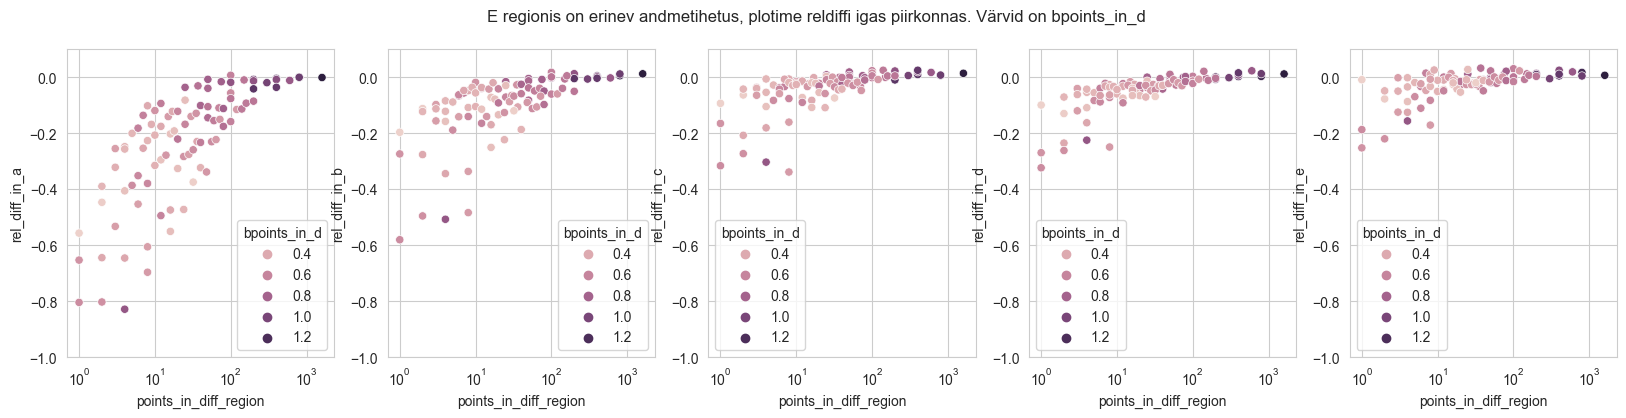

In [210]:
test_df = df[(df.region=="E")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_d" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_d", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_d", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_d", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_d", ax=ax[4])
plt.suptitle("E regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_d")
plt.show()

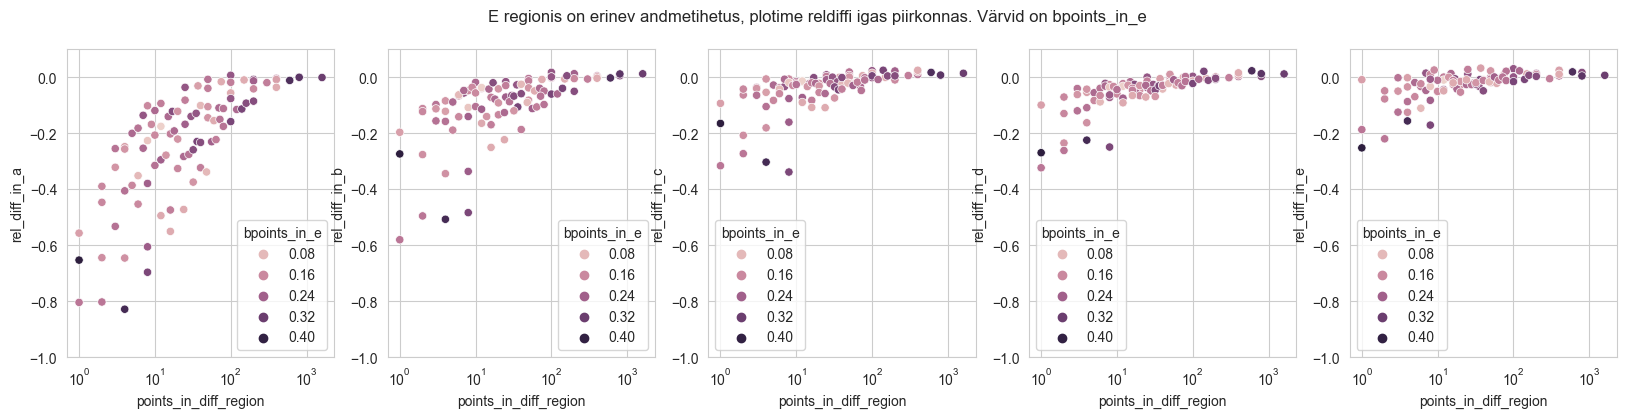

In [211]:
test_df = df[(df.region=="E")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_e" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="bpoints_in_e", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_e", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="bpoints_in_e", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_e", ax=ax[4])
plt.suptitle("E regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on bpoints_in_e")
plt.show()

## Protsent kogu mudeli bpointidest vastavas piirkonnas

In [213]:
df["rel_bpoints_in_a"] = df["bpoints_in_a"]/ (df["bpoints_in_a"]+df["bpoints_in_b"]+df["bpoints_in_c"]+df["bpoints_in_d"]+df["bpoints_in_e"])
df["rel_bpoints_in_b"] = df["bpoints_in_b"]/ (df["bpoints_in_a"]+df["bpoints_in_b"]+df["bpoints_in_c"]+df["bpoints_in_d"]+df["bpoints_in_e"])
df["rel_bpoints_in_c"] = df["bpoints_in_c"]/ (df["bpoints_in_a"]+df["bpoints_in_b"]+df["bpoints_in_c"]+df["bpoints_in_d"]+df["bpoints_in_e"])
df["rel_bpoints_in_d"] = df["bpoints_in_d"]/ (df["bpoints_in_a"]+df["bpoints_in_b"]+df["bpoints_in_c"]+df["bpoints_in_d"]+df["bpoints_in_e"])
df["rel_bpoints_in_e"] = df["bpoints_in_e"]/ (df["bpoints_in_a"]+df["bpoints_in_b"]+df["bpoints_in_c"]+df["bpoints_in_d"]+df["bpoints_in_e"])

### region A

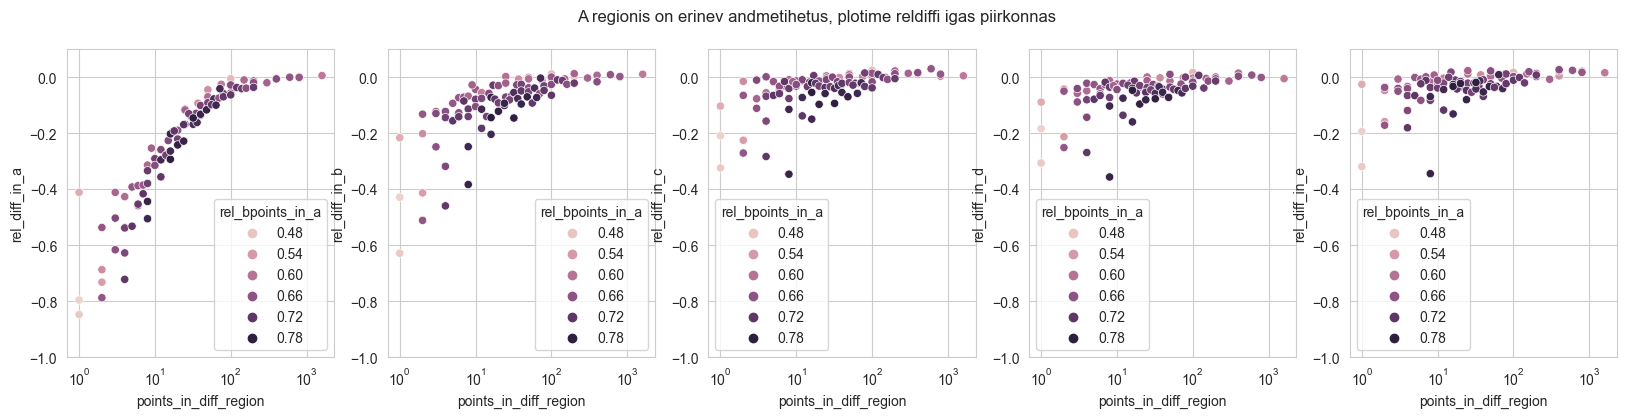

In [220]:
test_df = df[(df.region=="A")&(df.points_in_diff_region!=0)] #&(df.multiplier==2)
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
# plt.legend(loc='lower right')
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="rel_bpoints_in_a" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="rel_bpoints_in_a", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="rel_bpoints_in_a", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="rel_bpoints_in_a", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="rel_bpoints_in_a", ax=ax[4])
plt.suptitle("A regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas")
plt.show()

### region B

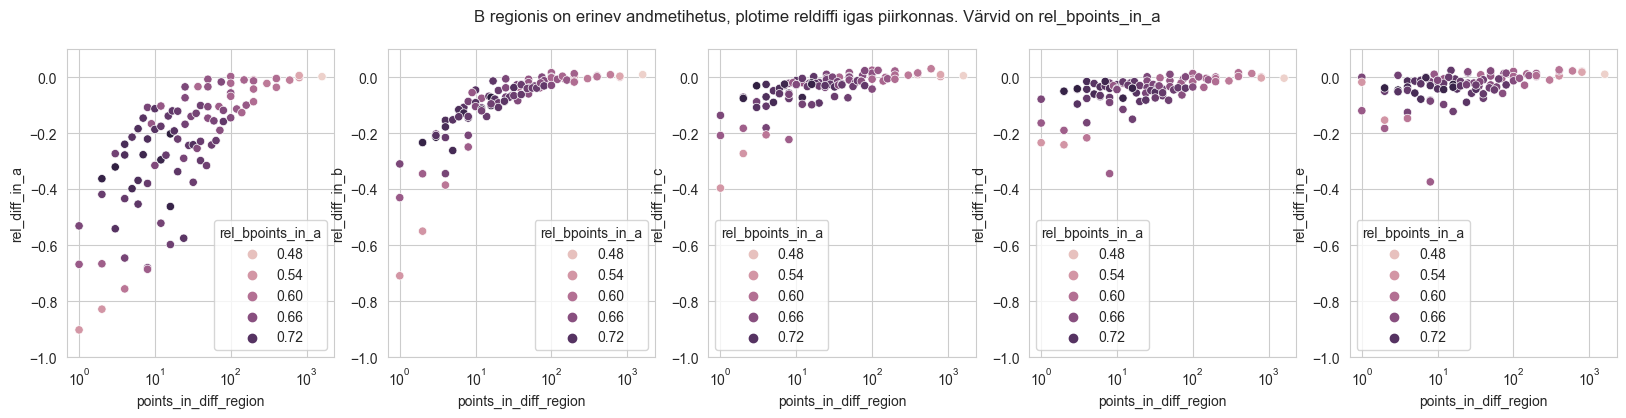

In [214]:
test_df = df[(df.region=="B")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="rel_bpoints_in_a" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="rel_bpoints_in_a", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="rel_bpoints_in_a", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="rel_bpoints_in_a", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="rel_bpoints_in_a", ax=ax[4])
plt.suptitle("B regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on rel_bpoints_in_a")
plt.show()

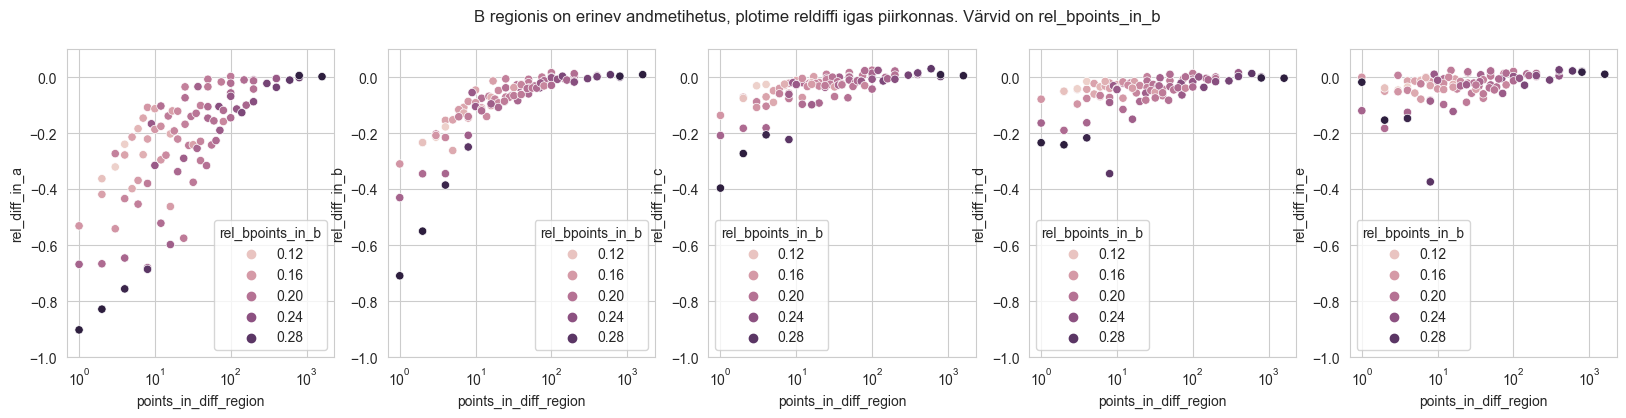

In [215]:
test_df = df[(df.region=="B")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="rel_bpoints_in_b" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="rel_bpoints_in_b", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="rel_bpoints_in_b", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="rel_bpoints_in_b", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="rel_bpoints_in_b", ax=ax[4])
plt.suptitle("B regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on rel_bpoints_in_b")
plt.show()

### region E

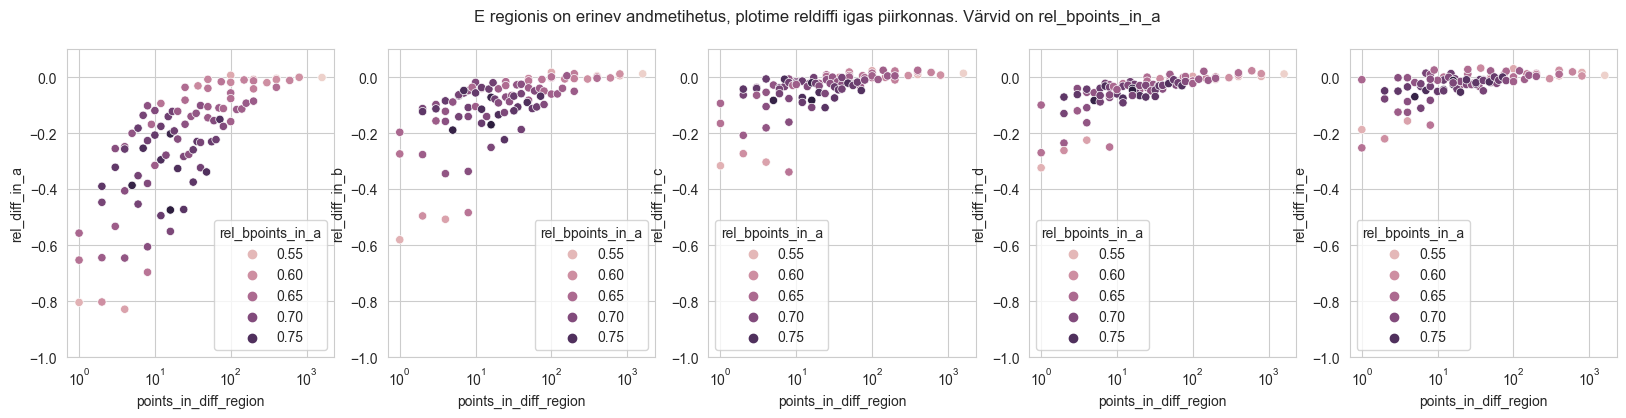

In [218]:
test_df = df[(df.region=="E")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="rel_bpoints_in_a" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="rel_bpoints_in_a", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="rel_bpoints_in_a", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="rel_bpoints_in_a", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="rel_bpoints_in_a", ax=ax[4])
plt.suptitle("E regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on rel_bpoints_in_a")
plt.show()

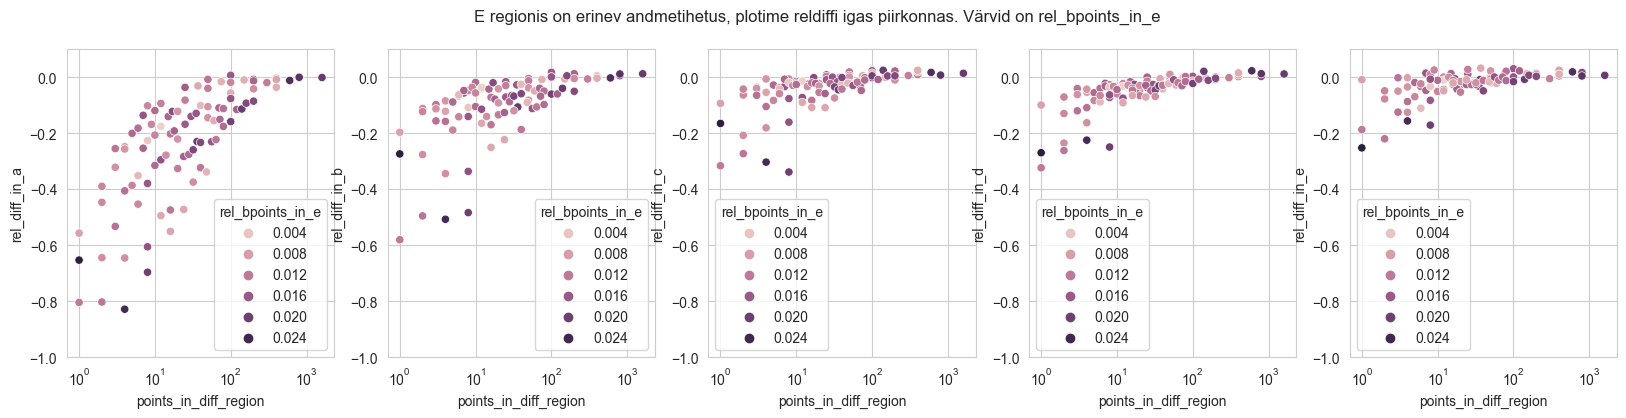

In [217]:
test_df = df[(df.region=="E")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
[a.set_ylim(-1, 0.1) for a in ax]
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="rel_bpoints_in_e" ,ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b",hue="rel_bpoints_in_e", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="rel_bpoints_in_e", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d",hue="rel_bpoints_in_e", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="rel_bpoints_in_e", ax=ax[4])
plt.suptitle("E regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas. Värvid on rel_bpoints_in_e")
plt.show()

<AxesSubplot: >

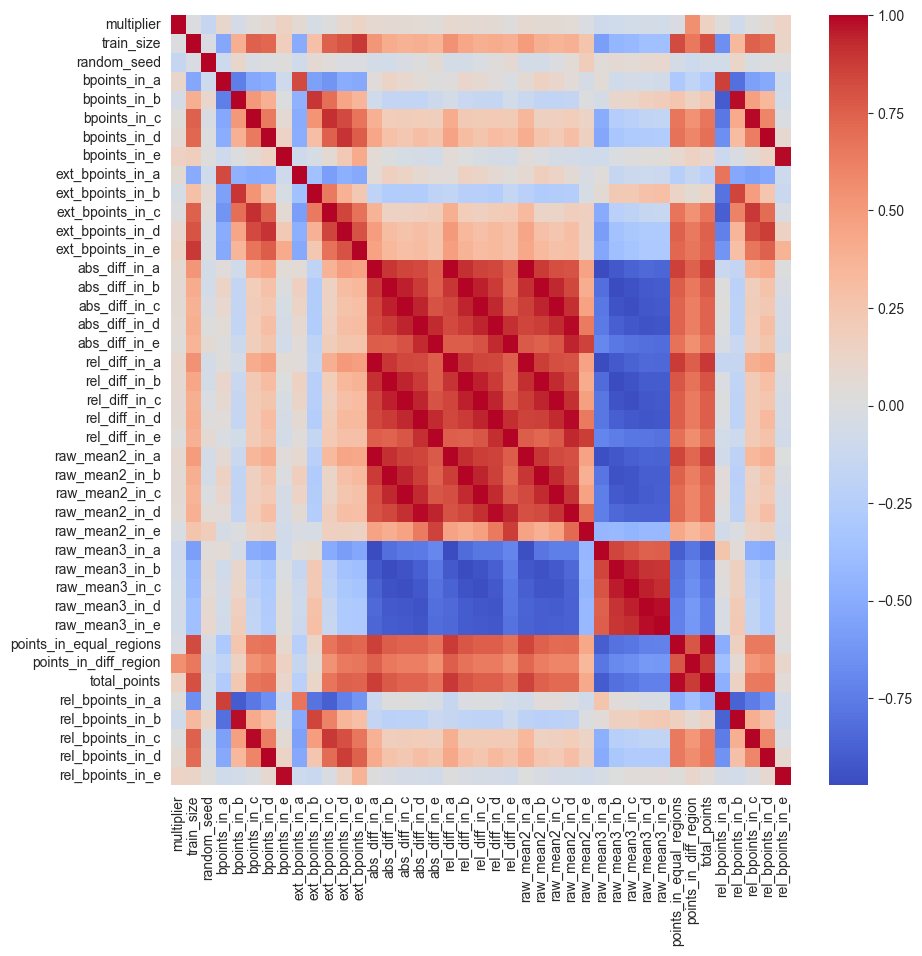

In [226]:
correl_df = df.copy()
correl_df = correl_df[correl_df.points_in_diff_region!=0]

correl_df["points_in_diff_region"] = np.log10(correl_df["points_in_diff_region"])
correl_df["points_in_equal_regions"] = np.log10(correl_df["points_in_equal_regions"])
correl_df["total_points"] = np.log10(correl_df["total_points"])
plt.figure(figsize=(10,10))
sns.heatmap(correl_df.corr(numeric_only=True),cmap="coolwarm", )